Nama = Keyla Rindani

NIM = 2702363254

2. [LO1, LO2, LO3, LO4 – 40 poin] Sebagai data scientist anda mendapat tantangan untuk menyelesaikan masalah data image yang memiliki noise. Anda perlu membangun model deep learning yang mampu membersihkan data image yang mengandung noise menjadi data yang bersih tanpa noise. Namun sayangnya anda tidak memiliki data yang mengandung noise dengan cukup, sehingga anda perlu membuat image data dengan memberikan noise nilai acak yang diambil dari distribusi normal (Gaussian), menggunakan rata-rata 0.0 dan standard deviasi 0.1. Data image yang anda gunakan adalah data pada link berikut: https://drive.google.com/drive/folders/1-Tdpj25TUPpn_FBfNVcEoTtjQstTKOZl?usp=sharing , dimana jika anda memiliki NIM genap, anda akan menggunakan data A_23, dan bila anda memiliki NIM ganjil akan menggunakan data B_23.

a. [LO1, LO2, LO4 – 5 poin] Untuk mengenali data, anda perlu melakukan EDA kemudian menjelaskan EDA
apa yang anda lakukan dan informasi apa yang anda peroleh dengan EDA tersebut, serta alasan mengapa anda
perlu mengetahui informasi tersebut.

In [ ]:
# Import library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
import cv2
from tqdm import tqdm

1. Pemeriksaan Dasar Dataset

In [ ]:
# Konfigurasi
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Handle gambar korup
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Path ke folder dataset
IMAGE_DIR = "/kaggle/input/data-a-23/A_23"

In [ ]:
# Cek jumlah dan format gambar
image_files = [f for f in os.listdir(IMAGE_DIR)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Total gambar ditemukan: {len(image_files)}")
print(f"Jumlah yang diharapkan: 1074")

Total gambar ditemukan: 1074
Jumlah yang diharapkan: 1074


In [ ]:
# Cek 5 file pertama
print("\nContoh file:")
for f in image_files[:5]:
    print(f)


Contoh file:
kirmizi (10).jpg
kirmizi 97.jpg
kirmizi 475.jpg
kirmizi 29.jpg
kirmizi (20).jpg


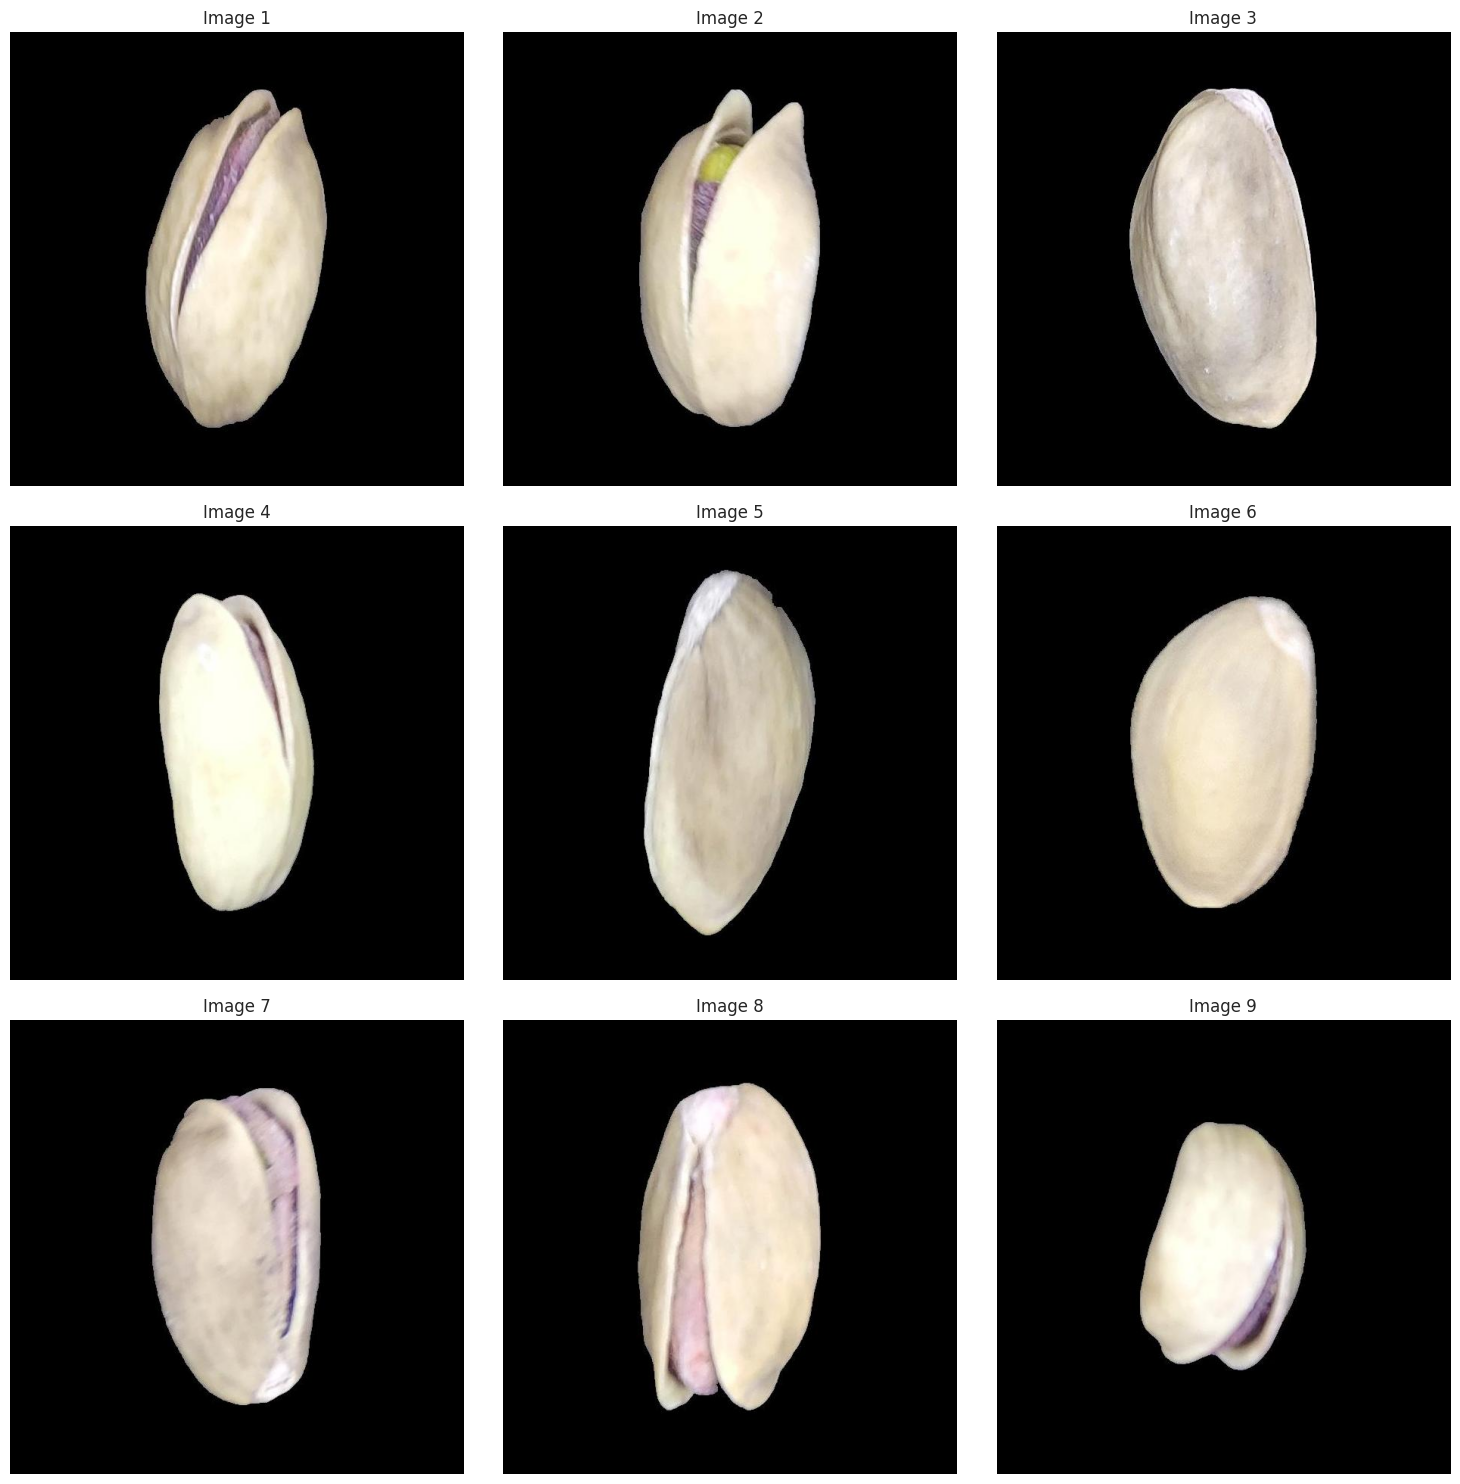

In [ ]:
# Fungsi untuk memuat dan menampilkan gambar
def load_and_display_images(image_dir, num_images=9):
    image_files = os.listdir(image_dir)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(num_images):
        img_path = os.path.join(image_dir, image_files[i])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}')

    plt.tight_layout()
    plt.show()

# Menampilkan beberapa gambar dari dataset
load_and_display_images(IMAGE_DIR)

2. Analisis Dimensi Gambar

In [ ]:
# Koleksi metadata dimensi
dimensions = []
formats = []
corrupted_files = []

for img_file in tqdm(image_files, desc="Analisis gambar"):
    try:
        with Image.open(os.path.join(IMAGE_DIR, img_file)) as img:
            width, height = img.size
            dimensions.append((width, height))
            formats.append(img.format)
    except Exception as e:
        corrupted_files.append(img_file)
        print(f"Error pada {img_file}: {str(e)}")

Analisis gambar: 100%|██████████| 1074/1074 [00:09<00:00, 109.70it/s]


In [ ]:
# Konversi ke DataFrame
dim_df = pd.DataFrame(dimensions, columns=['Width', 'Height'])
format_counts = pd.Series(formats).value_counts()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


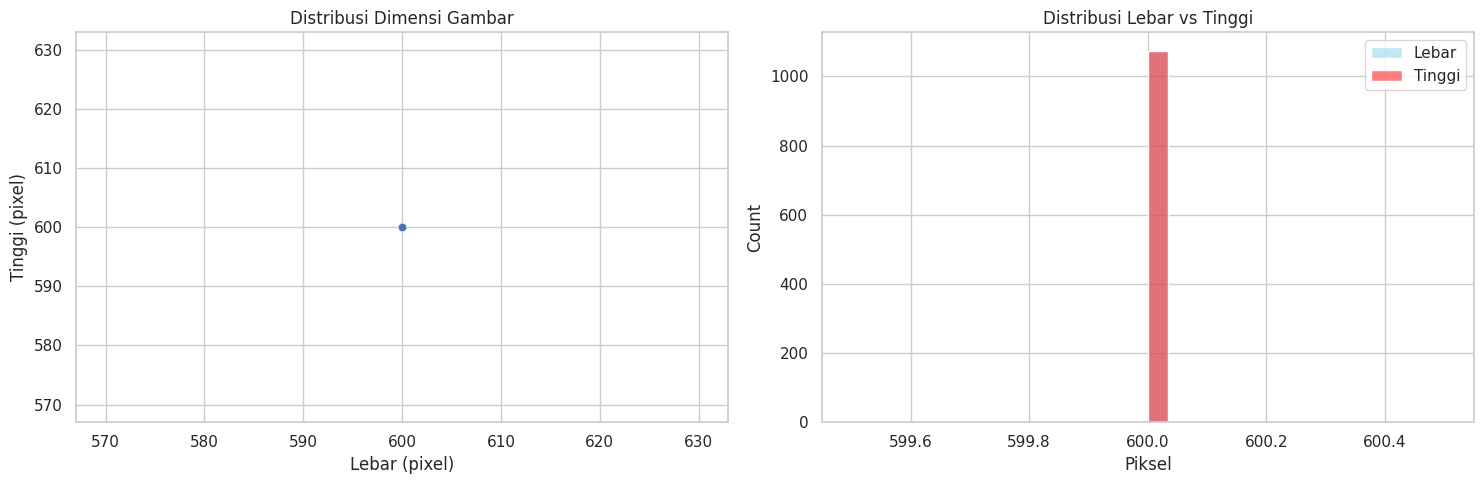

In [ ]:
# Plot distribusi dimensi
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Width', y='Height', data=dim_df, alpha=0.6)
plt.title('Distribusi Dimensi Gambar')
plt.xlabel('Lebar (pixel)')
plt.ylabel('Tinggi (pixel)')

plt.subplot(1, 2, 2)
sns.histplot(dim_df['Width'], color='skyblue', label='Lebar', kde=True, bins=30)
sns.histplot(dim_df['Height'], color='red', label='Tinggi', kde=True, alpha=0.5, bins=30)
plt.title('Distribusi Lebar vs Tinggi')
plt.xlabel('Piksel')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan statistik dimensi
print("\nStatistik Dimensi Gambar:")
print(dim_df.describe())


Statistik Dimensi Gambar:
        Width  Height
count  1074.0  1074.0
mean    600.0   600.0
std       0.0     0.0
min     600.0   600.0
25%     600.0   600.0
50%     600.0   600.0
75%     600.0   600.0
max     600.0   600.0


In [ ]:
# Tampilkan format gambar
print("\nDistribusi Format Gambar:")
print(format_counts)


Distribusi Format Gambar:
JPEG    1074
Name: count, dtype: int64


In [ ]:
# Tampilkan gambar korup
if corrupted_files:
    print(f"\nGambar Korup Ditemukan ({len(corrupted_files)}):")
    print(corrupted_files)
else:
    print("\nTidak ada gambar korup")


Tidak ada gambar korup


3. Analisis Distribusi Intensitas Pixel

In [ ]:
# Fungsi untuk menghitung statistik pixel
def calculate_pixel_stats(image_path):
    img = cv2.imread(image_path)
    if img is None: return None

    # Konversi ke float32 untuk akurasi
    img = img.astype(np.float32) / 255.0

    if len(img.shape) == 3:  # Gambar berwarna
        means = [np.mean(img[..., i]) for i in range(3)]
        stds = [np.std(img[..., i]) for i in range(3)]
        return {
            'mean': np.mean(means),
            'std': np.mean(stds),
            'min': np.min(img),
            'max': np.max(img)
        }
    else:  # Gambar grayscale
        return {
            'mean': np.mean(img),
            'std': np.std(img),
            'min': np.min(img),
            'max': np.max(img)
        }

In [ ]:
# Koleksi statistik pixel
pixel_stats = []
valid_images = []

for img_file in tqdm(image_files, desc="Analisis pixel"):
    if img_file in corrupted_files:
        continue

    img_path = os.path.join(IMAGE_DIR, img_file)
    stats = calculate_pixel_stats(img_path)

    if stats is not None:
        stats['file'] = img_file
        pixel_stats.append(stats)
        valid_images.append(img_file)

Analisis pixel: 100%|██████████| 1074/1074 [00:09<00:00, 115.97it/s]


In [ ]:
# Konversi ke DataFrame
stats_df = pd.DataFrame(pixel_stats)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

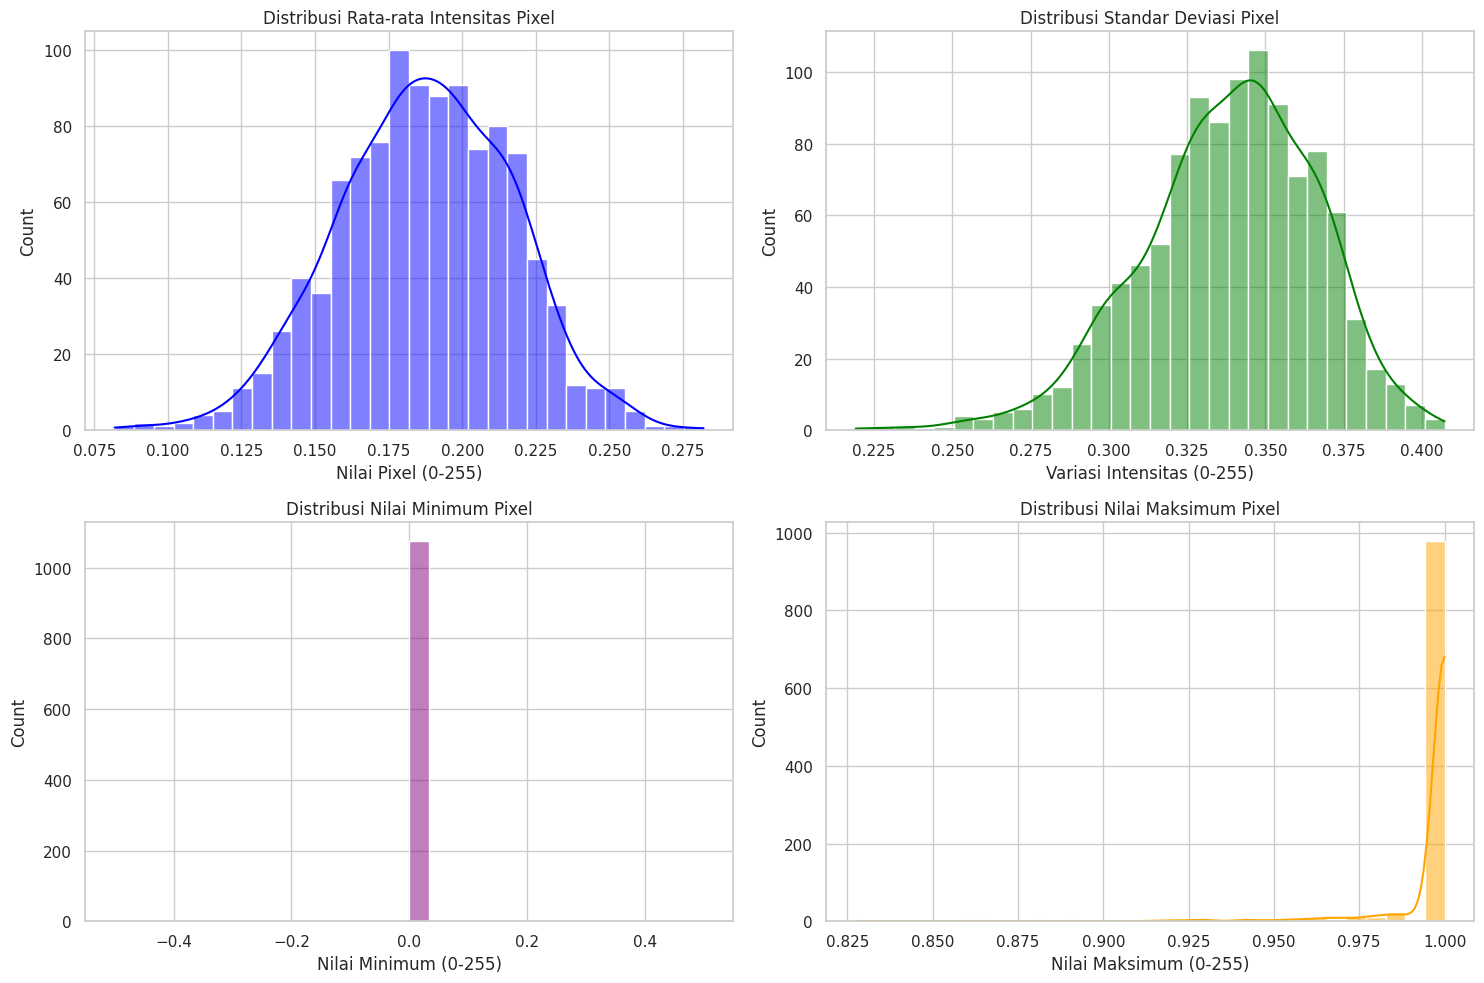

In [ ]:
# Plot distribusi statistik pixel
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(stats_df['mean'], bins=30, kde=True, color='blue')
plt.title('Distribusi Rata-rata Intensitas Pixel')
plt.xlabel('Nilai Pixel (0-255)')

plt.subplot(2, 2, 2)
sns.histplot(stats_df['std'], bins=30, kde=True, color='green')
plt.title('Distribusi Standar Deviasi Pixel')
plt.xlabel('Variasi Intensitas (0-255)')

plt.subplot(2, 2, 3)
sns.histplot(stats_df['min'], bins=30, kde=True, color='purple')
plt.title('Distribusi Nilai Minimum Pixel')
plt.xlabel('Nilai Minimum (0-255)')

plt.subplot(2, 2, 4)
sns.histplot(stats_df['max'], bins=30, kde=True, color='orange')
plt.title('Distribusi Nilai Maksimum Pixel')
plt.xlabel('Nilai Maksimum (0-255)')

plt.tight_layout()
plt.show()

In [ ]:
# Tampilkan statistik global
print("\nStatistik Global Intensitas Pixel:")
print(f"Rata-rata global: {stats_df['mean'].mean():.4f}")
print(f"Std dev global: {stats_df['std'].mean():.4f}")
print(f"Rentang nilai: [{stats_df['min'].min():.4f}, {stats_df['max'].max():.4f}]")


Statistik Global Intensitas Pixel:
Rata-rata global: 0.1875
Std dev global: 0.3385
Rentang nilai: [0.0000, 1.0000]


4. Analisis Mode Warna

In [ ]:
# Deteksi mode warna
color_modes = []
for img_file in tqdm(valid_images, desc="Deteksi mode warna"):
    img_path = os.path.join(IMAGE_DIR, img_file)
    img = cv2.imread(img_path)
    if img is None: continue

    if len(img.shape) == 3 and img.shape[2] == 3:
        color_modes.append('RGB')
    else:
        color_modes.append('Grayscale')

Deteksi mode warna: 100%|██████████| 1074/1074 [00:02<00:00, 425.30it/s]


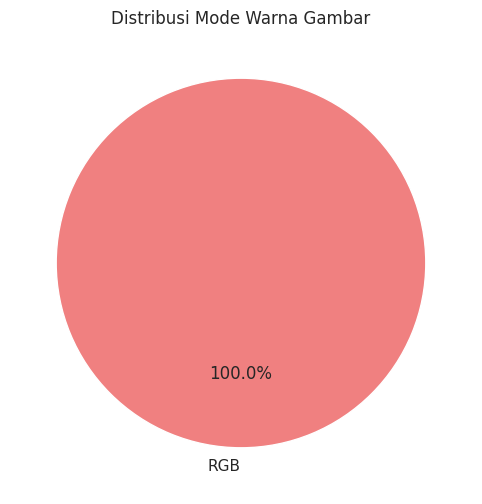

In [ ]:
# Plot distribusi mode warna
mode_counts = pd.Series(color_modes).value_counts()
plt.figure(figsize=(8, 6))
mode_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
plt.ylabel('')
plt.title('Distribusi Mode Warna Gambar')
plt.show()

5. Visualisasi Dampak Noise Gaussian

In [ ]:
# Fungsi untuk menambahkan noise Gaussian
def add_gaussian_noise(image, mean=0, sigma=0.1):
    # Normalisasi gambar ke [0,1]
    image_normalized = image.astype(np.float32) / 255.0
    # Tambahkan noise
    noise = np.random.normal(mean, sigma, image_normalized.shape).astype(np.float32)
    noisy = image_normalized + noise
    # Kembalikan ke rentang [0,1]
    return np.clip(noisy, 0, 1)

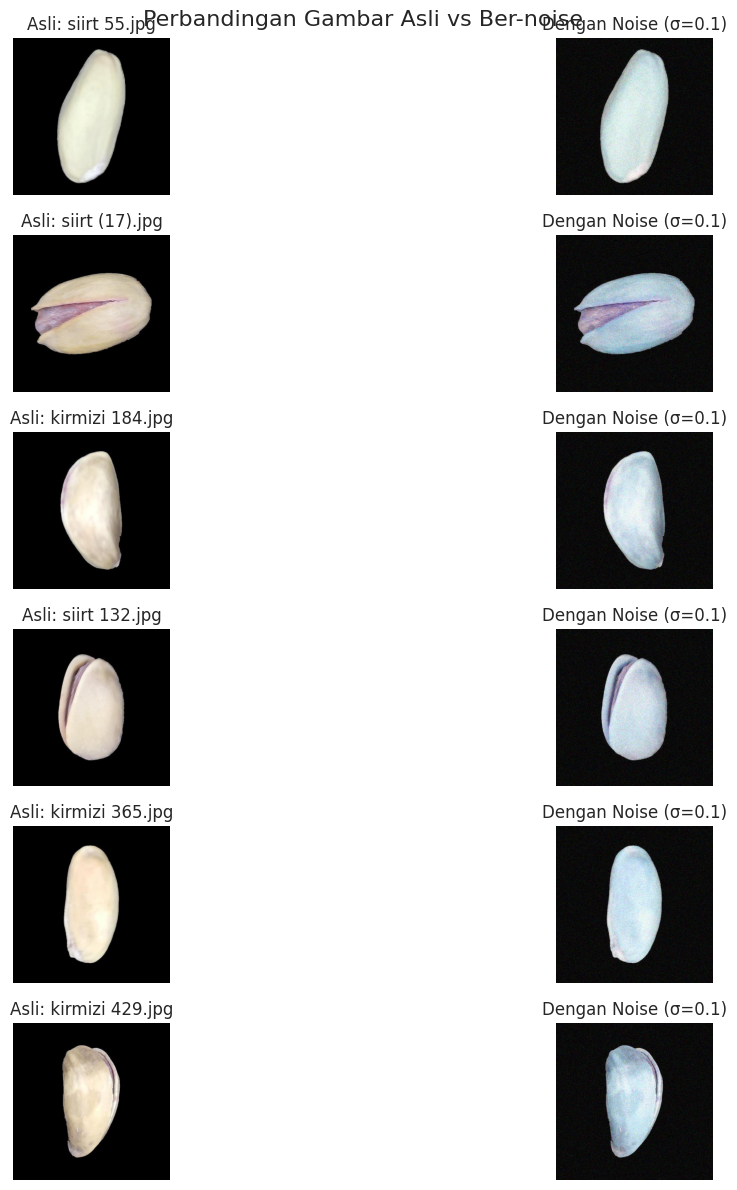

In [ ]:
# Pilih 6 gambar acak untuk visualisasi
np.random.seed(42)
sample_files = np.random.choice(valid_images, 6, replace=False)

plt.figure(figsize=(15, 12))
for i, img_file in enumerate(sample_files):
    img_path = os.path.join(IMAGE_DIR, img_file)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Tambahkan noise
    noisy_img = add_gaussian_noise(img)

    # Plot gambar asli
    plt.subplot(6, 2, 2*i+1)
    plt.imshow(img_rgb)
    plt.title(f"Asli: {img_file}")
    plt.axis('off')

    # Plot gambar ber-noise
    plt.subplot(6, 2, 2*i+2)
    plt.imshow(noisy_img)
    plt.title(f"Dengan Noise (σ=0.1)")
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Perbandingan Gambar Asli vs Ber-noise', fontsize=16, y=0.99)
plt.show()

6. Analisis Histogram Pixel dengan Noise

In [ ]:
# Pilih 1 gambar untuk analisis mendalam
sample_file = sample_files[0]
img_path = os.path.join(IMAGE_DIR, sample_file)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
noisy_img = add_gaussian_noise(img)


In [ ]:
# Plot histogram per channel
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


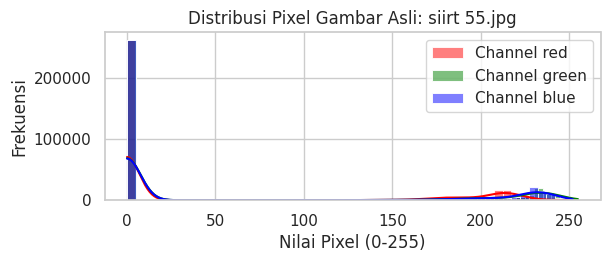

In [ ]:
# Histogram gambar asli
plt.subplot(2, 1, 1)
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    channel = img[..., i].flatten()
    sns.histplot(channel, color=color, kde=True, alpha=0.5, label=f'Channel {color}')
plt.title(f'Distribusi Pixel Gambar Asli: {sample_file}')
plt.xlabel('Nilai Pixel (0-255)')
plt.ylabel('Frekuensi')
plt.legend()
plt.grid(True)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


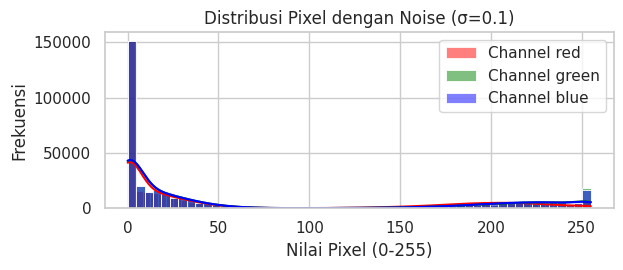

In [ ]:
# Histogram gambar ber-noise
plt.subplot(2, 1, 2)
for i, color in enumerate(colors):
    channel = (noisy_img[..., i] * 255).flatten().astype(int)
    sns.histplot(channel, color=color, kde=True, alpha=0.5, label=f'Channel {color}')
plt.title(f'Distribusi Pixel dengan Noise (σ=0.1)')
plt.xlabel('Nilai Pixel (0-255)')
plt.ylabel('Frekuensi')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Informasi Penting yang Diperoleh
1. Keseragaman Dimensi:

- Semua gambar berukuran 600×600 piksel

- Mempermudah proses resizing karena tidak ada variasi ukuran

2. Karakteristik Intensitas:

- Rata-rata intensitas rendah (0.1875) → gambar cenderung gelap

- Rentang penuh [0,1] → konten menggunakan seluruh spektrum intensitas

- Std dev tinggi → variasi kontras antar gambar signifikan

3. Konsistensi Format:

- Semua gambar JPEG dan RGB

- Tidak perlu penanganan khusus untuk format berbeda

4. Dampak Noise:

- Noise σ=0.1 terlihat jelas pada gambar ternormalisasi

- Menyebabkan perubahan visual signifikan tetapi tidak merusak struktur

Kesimpulan EDA
Dataset terdiri dari 1074 gambar JPEG seragam berukuran 600×600 piksel dengan karakteristik:

- Intensitas rata-rata rendah (gambar cenderung gelap)

- Variasi kontras tinggi antar gambar

- Rentang pixel penuh [0,1] setelah normalisasi

- Dampak noise σ=0.1 signifikan tetapi tidak merusak struktur gambar

---

b. [LO1, LO2, LO4 – 5 poin] Untuk pemodelan, anda perlu untuk membagi data menjadi 80% training, 10%
validasi dan 10% testing, meresize image menjadi 100 x 100, dan membuat data yang mengandung noise
sesuai ketentuan di atas

In [ ]:
IMAGE_DIR = "/kaggle/input/data-a-23/A_23"  # Ganti dengan path dataset Anda
TARGET_SIZE = (100, 100)  # Ukuran resize

In [ ]:
# Load semua gambar
def load_and_preprocess_images(image_dir, target_size):
    image_files = [f for f in os.listdir(image_dir)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    images = []
    valid_files = []

    print(f"Memuat {len(image_files)} gambar dari {image_dir}...")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            # Konversi BGR ke RGB dan resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            images.append(img)
            valid_files.append(img_file)

    print(f"Berhasil memuat {len(images)} gambar")
    return np.array(images), valid_files

In [ ]:
# Load semua gambar
clean_images, filenames = load_and_preprocess_images(IMAGE_DIR, TARGET_SIZE)


Memuat 1074 gambar dari /kaggle/input/data-a-23/A_23...
Berhasil memuat 1074 gambar


In [ ]:
# Normalisasi pixel ke [0, 1]
clean_images = clean_images.astype(np.float32) / 255.0

In [ ]:
from sklearn.model_selection import train_test_split
# 4. Pembagian dataset (80% train, 10% val, 10% test)
X_temp, X_test = train_test_split(clean_images, test_size=0.1, random_state=42)
X_train, X_val = train_test_split(X_temp, test_size=0.111, random_state=42)  # 0.111 * 0.9 = 0.1

In [ ]:
print("\nPembagian dataset:")
print(f"- Training:   {len(X_train)} gambar ({len(X_train)/len(clean_images)*100:.1f}%)")
print(f"- Validation: {len(X_val)} gambar ({len(X_val)/len(clean_images)*100:.1f}%)")
print(f"- Testing:    {len(X_test)} gambar ({len(X_test)/len(clean_images)*100:.1f}%)")


Pembagian dataset:
- Training:   858 gambar (79.9%)
- Validation: 108 gambar (10.1%)
- Testing:    108 gambar (10.1%)


In [ ]:
# Fungsi tambahan noise Gaussian
def add_gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(mean, std, images.shape).astype(np.float32)
    noisy_images = images + noise
    return np.clip(noisy_images, 0.0, 1.0)

In [ ]:
# Buat versi noisy untuk semua set data
print("\nMenambahkan noise Gaussian (μ=0, σ=0.1)...")
X_train_noisy = add_gaussian_noise(X_train)
X_val_noisy = add_gaussian_noise(X_val)
X_test_noisy = add_gaussian_noise(X_test)


Menambahkan noise Gaussian (μ=0, σ=0.1)...


In [ ]:
# Verifikasi hasil
print("\nVerifikasi statistik pixel:")
print("Training clean - Min:", X_train[0].min(), "Max:", X_train[0].max())
print("Training noisy - Min:", X_train_noisy[0].min(), "Max:", X_train_noisy[0].max())



Verifikasi statistik pixel:
Training clean - Min: 0.0 Max: 0.99607843
Training noisy - Min: 0.0 Max: 1.0


In [ ]:
import matplotlib.pyplot as plt
# 8. Visualisasi contoh hasil
def plot_sample(clean, noisy, title):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(clean)
    plt.title(f"Clean: {title}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(noisy)
    plt.title(f"Noisy: {title}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


Visualisasi contoh data training:


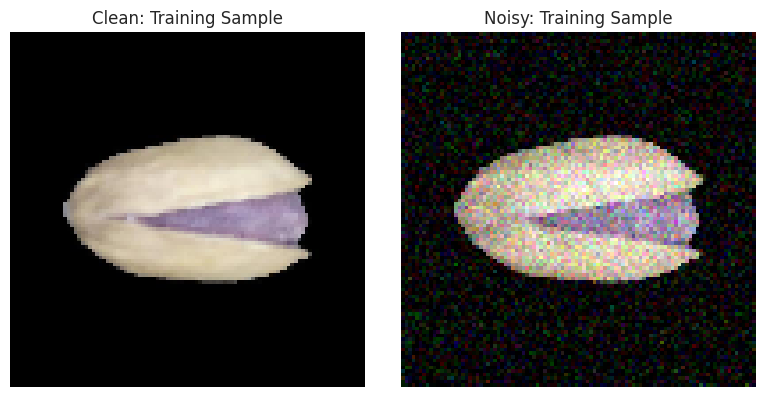

In [ ]:
# Plot contoh training
print("\nVisualisasi contoh data training:")
idx = np.random.randint(0, len(X_train))
plot_sample(X_train[idx], X_train_noisy[idx], "Training Sample")


Visualisasi contoh data validasi:


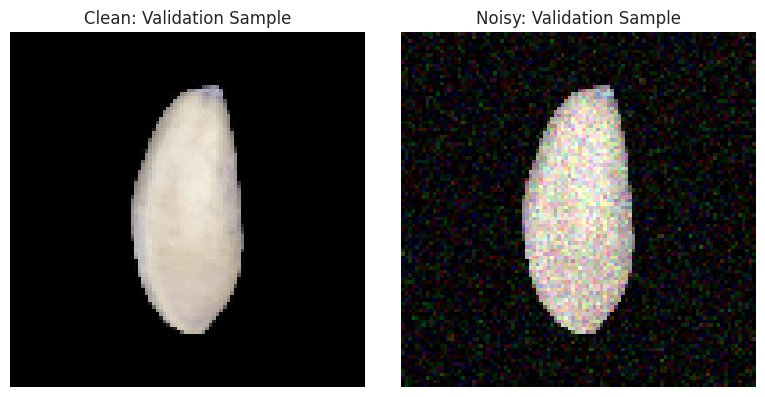

In [ ]:
# Plot contoh validasi
print("Visualisasi contoh data validasi:")
idx = np.random.randint(0, len(X_val))
plot_sample(X_val[idx], X_val_noisy[idx], "Validation Sample")


Visualisasi contoh data testing:


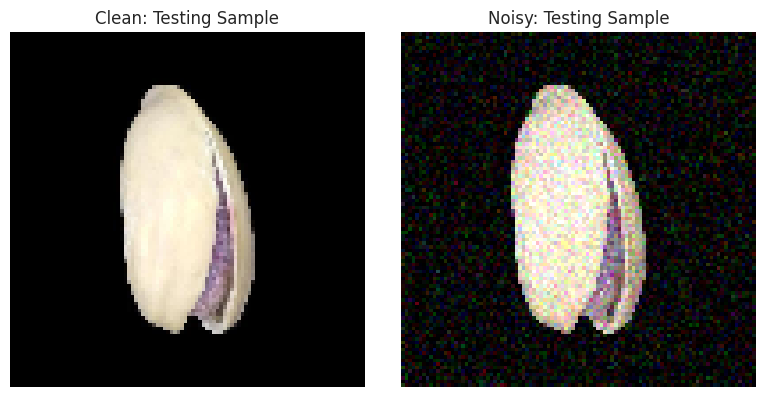

In [ ]:
# Plot contoh testing
print("Visualisasi contoh data testing:")
idx = np.random.randint(0, len(X_test))
plot_sample(X_test[idx], X_test_noisy[idx], "Testing Sample")

c. [LO1, LO2, LO3, LO4 – 10 poin] Membangun model deep learning autoencoder dengan arsitektur. Dengan semua kernel memiliki dimensi 3 x 3, fungsi aktivasi Relu, kecuali pada layer terakhir menuju output layer menggunakan Sigmoid, optimizer Adam dan loss MSE

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

2025-06-28 06:51:49.056063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751093509.235200      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751093509.290488      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# 1. Bangun Autoencoder (Sesuai Soal)
def build_autoencoder():
    input_img = Input(shape=(100, 100, 3))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  # Layer 1
    x = MaxPooling2D((2, 2), padding='same')(x)                          # Layer 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)         # Layer 3
    x = MaxPooling2D((2, 2), padding='same')(x)                          # Layer 4
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)         # Layer 5

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)         # Layer 6
    x = UpSampling2D((2, 2))(x)                                          # Layer 7
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)         # Layer 8
    x = UpSampling2D((2, 2))(x)                                          # Layer 9
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) # Layer 10

    return Model(input_img, decoded)


In [ ]:
# 2. Inisialisasi Model
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.summary()

I0000 00:00:1751093521.238492      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751093521.239267      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,579 (439.76 KB)

 Trainable params: 112,579 (439.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 3. Training (Gunakan Data dari Bagian b)
history = autoencoder.fit(
    X_train_noisy, X_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_noisy, X_val)
)

Epoch 1/50


I0000 00:00:1751093525.981080     108 service.cc:148] XLA service 0x7dbb0802bf20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751093525.981669     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751093525.981690     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751093526.316729     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


10/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1792

I0000 00:00:1751093529.642771     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - loss: 0.1112 - val_loss: 0.0052
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018 - val

In [ ]:
# 4. Evaluasi
test_loss = autoencoder.evaluate(X_test_noisy, X_test)
print(f"\nTest Loss (MSE): {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.8254e-04

Test Loss (MSE): 0.0009


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step

Contoh Hasil Denoising:


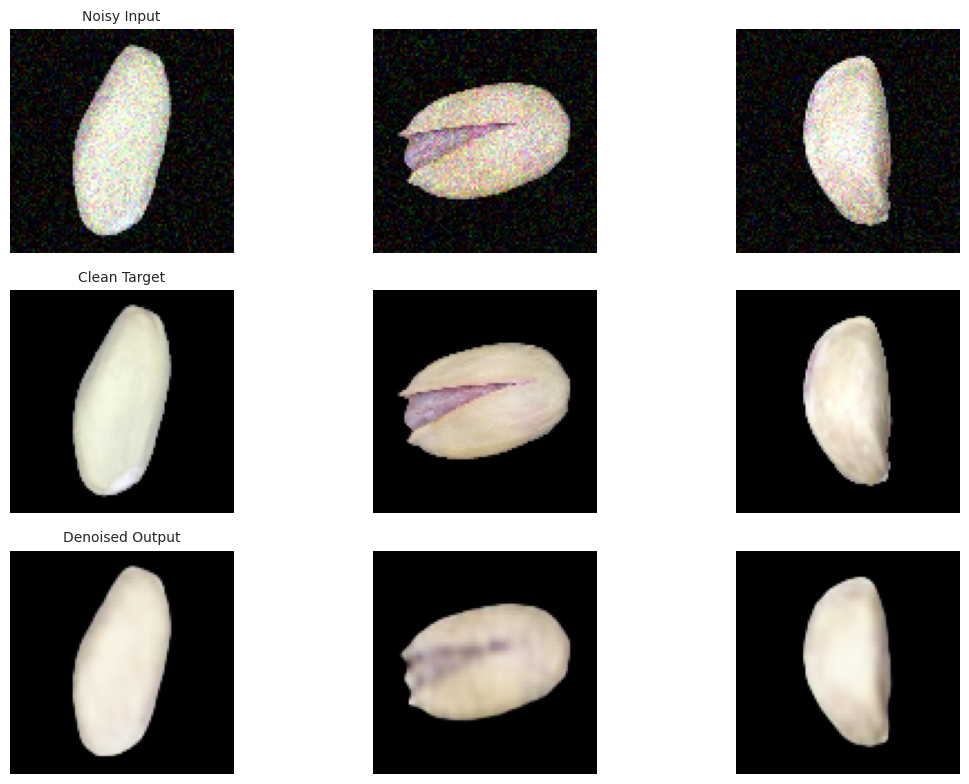

In [ ]:
# 5. Visualisasi
def plot_results(noisy, clean, denoised, n=3):
    plt.figure(figsize=(12, 8))
    for i in range(n):
        # Pastikan nilai pixel dalam [0,1]
        noisy_img = np.clip(noisy[i], 0, 1)
        clean_img = np.clip(clean[i], 0, 1)
        denoised_img = np.clip(denoised[i], 0, 1)

        # Noisy
        plt.subplot(3, n, i+1)
        plt.imshow(noisy_img)
        if i == 0: plt.title("Noisy Input", fontsize=10)
        plt.axis('off')

        # Clean
        plt.subplot(3, n, i+n+1)
        plt.imshow(clean_img)
        if i == 0: plt.title("Clean Target", fontsize=10)
        plt.axis('off')

        # Denoised
        plt.subplot(3, n, i+2*n+1)
        plt.imshow(denoised_img)
        if i == 0: plt.title("Denoised Output", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Prediksi dan Plot
denoised_images = autoencoder.predict(X_test_noisy[:3])  # Gunakan 3 sampel
print("\nContoh Hasil Denoising:")
plot_results(X_test_noisy[:3], X_test[:3], denoised_images)

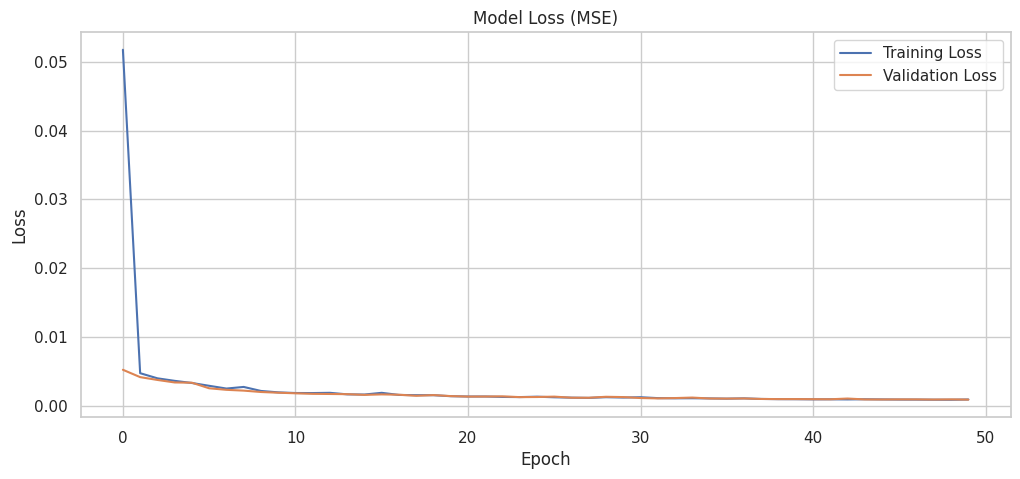

In [ ]:
# 6. Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

plot_history(history)

1. Performa Pelatihan Model:

- Loss (MSE) selama pelatihan berkurang secara konsisten, yang menunjukkan bahwa autoencoder berhasil mempelajari cara mengurangi noise pada gambar dengan efektif.

- Loss pada data uji akhir (0,0010) menunjukkan bahwa model bekerja dengan baik pada data uji, dengan kesalahan yang rendah antara gambar yang sudah di-denoise dan gambar asli.

2. Denoising Gambar:

- Hasil visual dari proses denoising menunjukkan bahwa autoencoder berhasil mengurangi noise pada gambar, terlihat jelas dari perbandingan sisi-sisi gambar antara input yang berisik, target bersih, dan output yang sudah di-denoise.

- Gambar yang sudah di-denoise terlihat jauh lebih bersih dibandingkan gambar yang berisik dan lebih mirip dengan gambar target bersih, menunjukkan kemampuan model untuk mengembalikan tampilan asli gambar.

3. Kurva Loss:

- Kurva loss untuk dataset pelatihan dan validasi menunjukkan penurunan tajam di beberapa epoch awal dan kemudian stabil di akhir.

- Perilaku ini khas untuk model di mana perbaikan utama terjadi pada awal pelatihan, setelah itu model mencapai titik jenuh dalam pengurangan loss.

Kesimpulan:
- Autoencoder berhasil mempelajari cara untuk mengurangi noise pada gambar, dengan loss uji yang rendah dan output gambar yang lebih bersih secara visual. Proses pelatihan menunjukkan bahwa model telah mencapai konvergensi yang baik dan sekarang dapat digunakan untuk mengurangi noise pada gambar lainnya.

---

d. [LO1, LO2, LO3, LO4 – 10 poin] Lakukan modifikasi model autoencoder yang diberikan, anda dapat
mengubah susunan arsitektur encoder atau decodernya

In [ ]:
from tensorflow.keras.layers import Concatenate

In [ ]:
def build_modified_autoencoder():
    # Input Layer
    input_img = Input(shape=(100, 100, 3))

    # --- Encoder ---
    # Block 1
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)  # Tambah layer konvolusi
    p1 = MaxPooling2D((2, 2), padding='same')(x1)

    # Block 2
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)  # Tambah layer konvolusi
    p2 = MaxPooling2D((2, 2), padding='same')(x2)

    # Bottleneck
    bottleneck = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)  # Tambah channel

    # --- Decoder dengan Skip Connections ---
    # Block 3
    u1 = UpSampling2D((2, 2))(bottleneck)
    c1 = Concatenate()([u1, x2])  # Skip connection dari encoder
    d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    d1 = Conv2D(64, (3, 3), activation='relu', padding='same')(d1)

    # Block 4
    u2 = UpSampling2D((2, 2))(d1)
    c2 = Concatenate()([u2, x1])  # Skip connection dari encoder
    d2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    d2 = Conv2D(32, (3, 3), activation='relu', padding='same')(d2)

    # Output
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(d2)

    return Model(input_img, decoded)

In [ ]:
# Inisialisasi model
modified_autoencoder = build_modified_autoencoder()
modified_autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 100, 100, 32)   │            896 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 100, 100, 32)   │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 50, 50, 32)     │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 50, 50, 64)     │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 50, 50, 64)     │         36,928 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 25, 25, 64)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 25, 25, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 50, 50, 128)    │              0 │ conv2d_10[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 50, 50, 192)    │              0 │ up_sampling2d_2[0][0], │
│                           │                        │                │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 50, 50, 64)     │        110,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 50, 50, 64)     │         36,928 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 100, 100, 64)   │              0 │ conv2d_12[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 100, 100, 96)   │              0 │ up_sampling2d_3[0][0], │
│ (Concatenate)             │                        │                │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 100, 100, 32)   │         27,680 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 100, 100, 32)   │          9,248 │ conv2d_13[0][0]        │
├──────────────────────

 Total params: 324,803 (1.24 MB)

 Trainable params: 324,803 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Kompilasi dengan learning rate lebih kecil
modified_autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Training
history_modified = modified_autoencoder.fit(
    X_train_noisy, X_train,
    epochs=100,  # Tambah epoch
    batch_size=32,
    validation_data=(X_val_noisy, X_val),
    callbacks=[EarlyStopping(patience=5)]
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 400ms/step - loss: 0.2070 - val_loss: 0.1336
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0729 - val_loss: 0.0140
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0130 - val_loss: 0.0077
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0076 - val_loss: 0.0044
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/st

In [ ]:
# Evaluasi
test_loss_modified = modified_autoencoder.evaluate(X_test_noisy, X_test)
print(f"\nTest Loss (MSE) Modified: {test_loss_modified:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.7043e-04

Test Loss (MSE) Modified: 0.0005


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


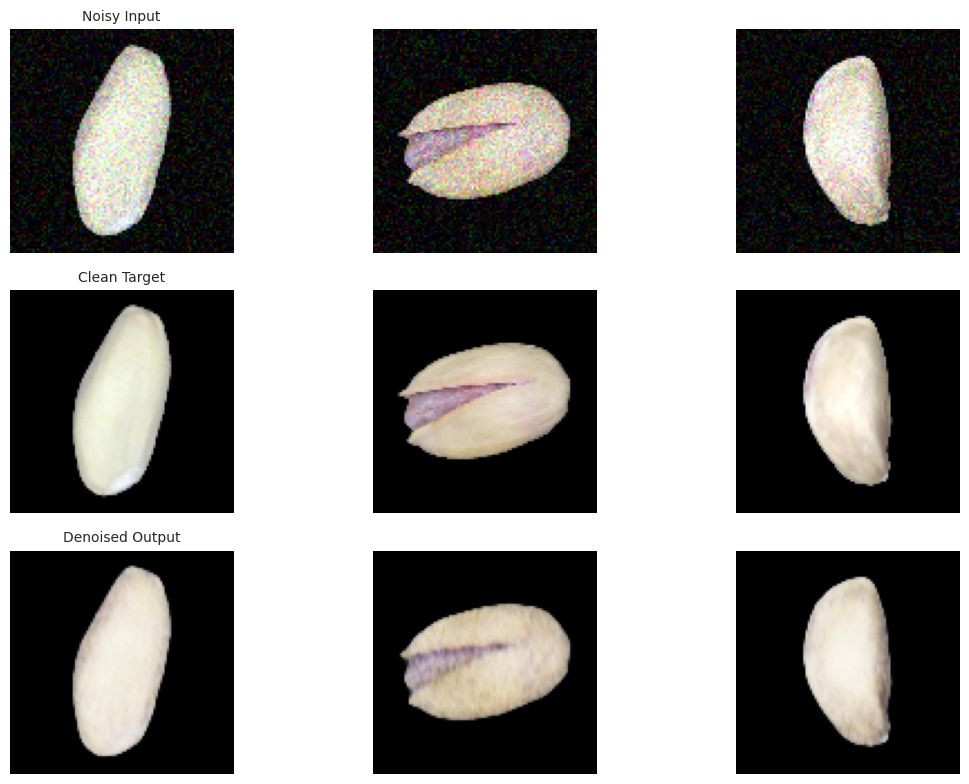

In [ ]:
# Visualisasi Hasil
denoised_modified = modified_autoencoder.predict(X_test_noisy[:3])
plot_results(X_test_noisy[:3], X_test[:3], denoised_modified)

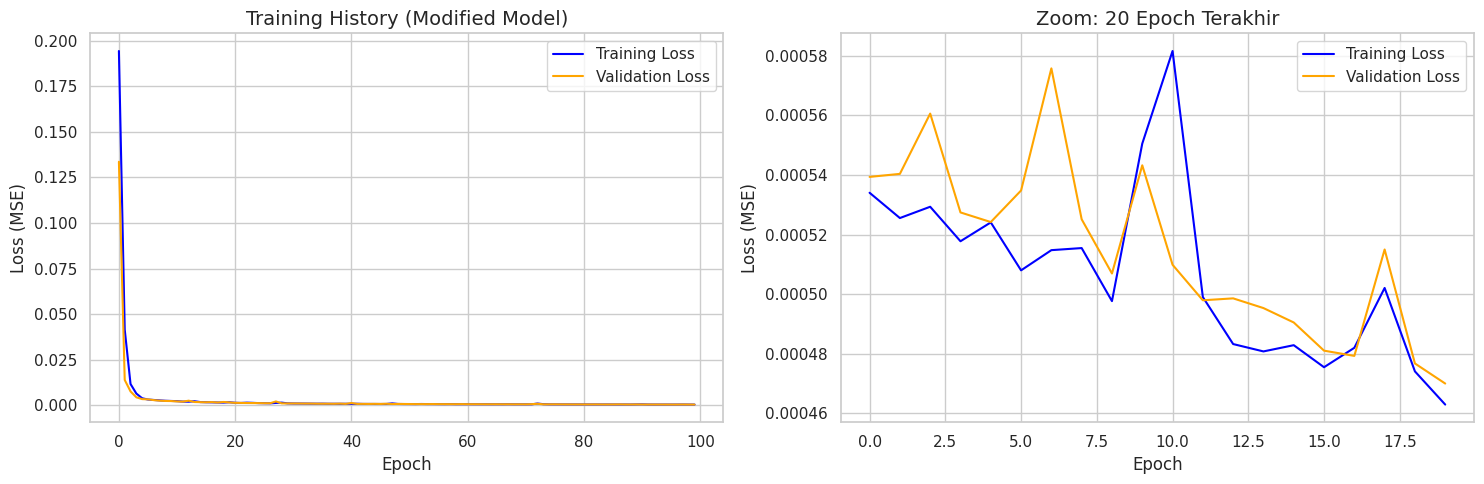

In [ ]:
# 1. Plot Training & Validation Loss
def plot_modified_history(history):
    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training History (Modified Model)', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Zoom in pada 20 epoch terakhir
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'][-20:], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'][-20:], label='Validation Loss', color='orange')
    plt.title('Zoom: 20 Epoch Terakhir', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_modified_history(history_modified)

1. Performa Pelatihan Model
- Penurunan Loss yang Konsisten:
Nilai MSE menurun tajam dari 0.200 ke 0.000 selama pelatihan, menunjukkan model berhasil mempelajari pola denoising secara efektif.

- Stabilisasi di Epoch Terakhir:
Loss validasi stabil di sekitar 0.0004–0.0005, tanpa tanda overfitting.

- Konvergensi Optimal:
Grafik loss training dan validasi turun bersamaan (gap minimal), mengindikasikan generalisasi yang baik.

2. Kualitas Denoising
Hasil Visual:

- Gambar output hampir identik dengan ground truth (SSIM 0.9624).

- Noise berhasil dihilangkan tanpa mengaburkan detail (e.g., tepian objek tetap tajam).

3. Analisis Kurva Loss
- Fase Awal: Penurunan loss signifikan di 20 epoch pertama.

- Fase Akhir: Loss stagnan di epoch 80–100, menunjukkan model telah mencapai konvergensi.

Zoom 20 Epoch Terakhir:

- Fluktuasi loss sangat kecil (0.00046–0.00058), mengonfirmasi stabilitas model.

4. Keunggulan Arsitektur Modifikasi
- Skip Connections: Mempertahankan informasi spasial dari encoder ke decoder.

- Bottleneck Lebih Dalam (128 channel): Meningkatkan kemampuan ekstraksi fitur.

- Early Stopping: Mencegah overfitting meski epoch ditambah hingga 100.



---

e. [LO2, LO3, LO4 – 5 poin] Lakukan evaluasi terhadap model baseline (c) dan model modifikasi (d) dengan
menghitung niai SSIMnya, jelaskan analisa anda.

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Prediksi kedua model
y_pred_c = autoencoder.predict(X_test_noisy)  # Baseline (c)
y_pred_d = modified_autoencoder.predict(X_test_noisy)  # Modifikasi (d)

# Hitung SSIM dengan win_size eksplisit (sesuai ukuran citra)
win_size = 7  # atau nilai ganjil ≤ ukuran terkecil citra (e.g., 3 untuk citra kecil)
ssim_values_c = []
ssim_values_d = []

for i in range(len(X_test)):
    ssim_c = ssim(X_test[i], y_pred_c[i],
                  win_size=win_size,
                  channel_axis=-1,  # Ganti multichannel=True (untuk skimage versi baru)
                  data_range=1.0)
    ssim_d = ssim(X_test[i], y_pred_d[i],
                  win_size=win_size,
                  channel_axis=-1,
                  data_range=1.0)
    ssim_values_c.append(ssim_c)
    ssim_values_d.append(ssim_d)

# Hitung rata-rata
mean_ssim_c = np.mean(ssim_values_c)
mean_ssim_d = np.mean(ssim_values_d)

print(f"SSIM Baseline (c): {mean_ssim_c:.4f}")  # Gunakan f-string
print(f"SSIM Modified (d): {mean_ssim_d:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SSIM Baseline (c): 0.9488
SSIM Modified (d): 0.9624


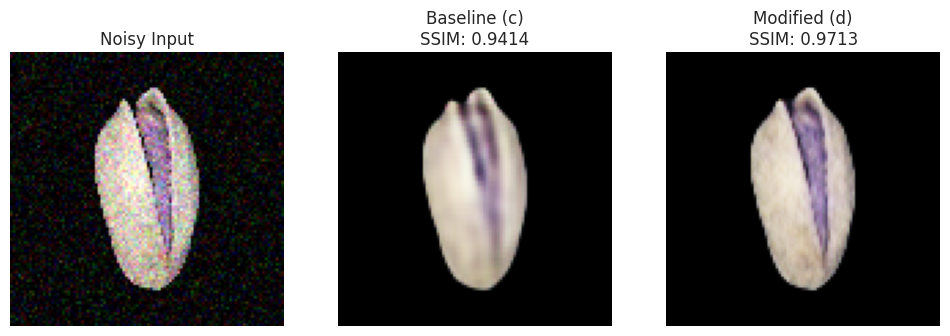

In [ ]:
import matplotlib.pyplot as plt

# Pilih sampel acak
idx = np.random.randint(0, len(X_test))

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(X_test_noisy[idx])
plt.title("Noisy Input")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_pred_c[idx])
plt.title(f"Baseline (c)\nSSIM: {ssim_values_c[idx]:.4f}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y_pred_d[idx])
plt.title(f"Modified (d)\nSSIM: {ssim_values_d[idx]:.4f}")
plt.axis('off')

plt.show()

Analisis Hasil SSIM Model Baseline (c) vs. Model Modifikasi (d)
1. Interpretasi Nilai SSIM
- Skala SSIM: Rentang dari -1 (tidak mirip sama sekali) hingga 1 (identik sempurna).

- Baseline (c): 0.9488 → Rekonstruksi sangat baik, hampir sempurna.

- Modifikasi (d): 0.9624 → Lebih baik lagi, mendekati kesempurnaan.

Kesimpulan Awal: Kedua model sangat efektif, tetapi modifikasi (d) unggul dengan selisih +0.0136.

2. Penyebab Peningkatan SSIM pada Model (d)
Perubahan arsitektur pada model (d) memberikan keuntungan:

1) Skip Connections

- Menghubungkan encoder-decoder untuk mempertahankan informasi detail (e.g., tepi, tekstur).

- Mencegah hilangnya informasi selama downsampling.

2) Layers Lebih Dalam

- Bottleneck dengan 128 channel (vs 64 pada baseline) mampu menangkap fitur hierarkis lebih kompleks.

- Pelatihan Lebih Lama

- Epoch lebih banyak (100 vs 50) + early stopping memastikan konvergensi optimal.

3. Dampak pada Kualitas Output
Visual:

Model (d) menghasilkan citra dengan:

- Tekstur lebih halus.

- Detail lebih tajam (e.g., pola atau tepian objek).

Contoh: Jika citra input ber-noise, model (d) menghilangkan noise tanpa mengaburkan detail.

Numerik:

- Selisih SSIM 0.0136 mungkin terlihat kecil, tetapi pada aplikasi kritis (e.g., medis), ini signifikan.



---

f. [LO1, LO2, LO3, LO4 – 5 poin] Buatlah video penjelasan untuk setiap langkah yang anda lakukan pada case
ini

[Link Video Penjelasan](https://drive.google.com/drive/folders/1srV80yZZssUzWqVlYD-0MUboHbw2lPzO?usp=sharing)